# NAO example notebook

This notebook contains an example of access of ERA5 data with the `Teleconnection` class and evaluation of the NAO teleconnection (station based index) with `aqua` libraries and an example of the plotting routines for one experiment only.

## Content

1. [The load of packages, modules, and data](#the-load-of-packages-modules-and-data)
2. [The Run method](#the-run-method)
3. [Index evaluation](#index-evaluation)
4. [Regression evaluation](#regression-evaluation)
5. [Correlation evaluation](#correlation-evaluation)
6. [Comparison with NCAR data](#comparison-with-ncar-data)

## The load of packages, modules, and data

The only import needed is the `Teleconnection` class from the `teleconnections` module.

In [5]:
from teleconnections.tc_class import Teleconnection

### Teleconnection details configuration

To run a teleconnection analysis, we only need to specify the teleconnection name and the catalog entry to be loaded by the `Reader` inside the class.

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools` module, that access details from a `yaml` file.

A configuration file is provided in the `config` folder, while a command line interface is provided in the `cli` folder, with a `yaml` file for access of a specific teleconnection analysis and experiment.

The minimum amount of information needed to run a teleconnection analysis is the teleconnection name and the catalog entry to be loaded by the `Reader` inside the class.
Note that with this minimum amount of information data will be loaded with no regridding or time aggregation, so be sure to access a source with roughly 1 degree resolution and monthly frequency.
Custom regridding and time aggregation can be specified with `regrid='r100` and `freq='monthly'` arguments in the `Teleconnection` class.

In [6]:
telecname = 'NAO'

model = 'ERA5'
exp = 'era5'
source = 'monthly'

### Initialize the class

Data required for the NAO teleconnection are retrieved with the `Reader` class from the `AQUA` framework in the `__init__` method of the class.

A logger is initialized to print out information on the screen.
We keep here `loglevel='INFO'` in order to print out what is happening in the notebook, but it can be set to `loglevel='WARNING'` to avoid printing out useless information in a production environment.

In [7]:
telec = Teleconnection(model=model, exp=exp, source=source, telecname=telecname, loglevel='INFO')

2023-07-07 16:43:59 :: Teleconnection :: WARNING  -> No regridding will be performed
2023-07-07 16:43:59 :: Teleconnection :: INFO     -> Be sure that the data is already regridded
2023-07-07 16:43:59 :: Teleconnection :: WARNING  -> No time aggregation will be performed
2023-07-07 16:43:59 :: Teleconnection :: INFO     -> Be sure that the data is already monthly aggregated
2023-07-07 16:43:59 :: Teleconnection :: INFO     -> Namelist loaded
2023-07-07 16:44:00 :: Teleconnection :: INFO     -> Reader initialized


Notice that warning about regridding and time aggregation are printed out, since we are not specifying any of them.

## The Run method

At this stage data are not retrieved yet, but they will be retrieved automatically with the index evaluation.
The most compact way of performing the teleconnection analysis is to use the `run` method of the class.

The method executes the following steps:
- data retrieval
- index evaluation
- regression evaluation
- correlation evaluation

With the current logging level, the method prints out information about the teleconnection analysis, and the data retrieval.
Notice also that the logging level is passed to the `Reader` class and other fuctions, so that information about the data retrieval is printed out as well.

These methods can be executed separately, as shown in the following sections.

In [8]:
telec.run()

2023-07-07 16:45:41 :: Reader :: INFO     -> Retrieving variables: ['msl']


2023-07-07 16:45:43 :: Reader :: INFO     -> msl: Pa --> Pa
2023-07-07 16:45:43 :: Reader :: INFO     -> Data model: /home/b/b382289/AQUA/config/data_models/cf2cds.json
2023-07-07 16:45:43 :: Teleconnection :: INFO     -> Data retrieved
2023-07-07 16:45:43 :: station based index :: INFO     -> Evaluating station based index for NAO
/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]
2023-07-07 16:45:43 :: station based index :: INFO     -> Data longitudes are 0-360, converting teleconnection coords
2023-07-07 16:45:43 :: station based index :: INFO     -> Station 1: lon = 334.3, lat = 37.7
2023-07-07 16:45:43 :: station based index :: INFO     -> Station 2: lon = 338, lat = 64.1
2023-07-07 16:46:16 :: station based index :: INFO     -> Index evaluated
2023-07-07 16:46:16 :: Regression :: INFO     -> Computing regr

At the end of the `run()` method, the data are saved in teleconnection class attributes.
The current phylosophy is to keep the data in the class, so that they can be accessed later on for further analysis or plotting.

Data are stored as xarray `DataArray`, with the following names:

- `self.data`: the original data (as DataSet)
- `self.index`: the index data
- `self.regression`: the regression data
- `self.correlation`: the correlation data

They can be acces then as (in this example):

```python
telec.index
```

## Index evaluation

We now show the individual steps of the teleconnection analysis and plot the results.

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.
The index can be evaluated with a custom rolling window to average data (standard is 3 months, it can be specified as argument `month_windows` while initializing the Teleconnection class).

In [9]:
telec.evaluate_index()

2023-07-07 16:50:20 :: Teleconnection :: WARNING  -> Index already calculated, skipping


Notice that a warning is printed out, since with the `run()` method we already evaluated the index.
The index is stored in the `self.index` attribute of the class, and an internal method to plot the index is provided.

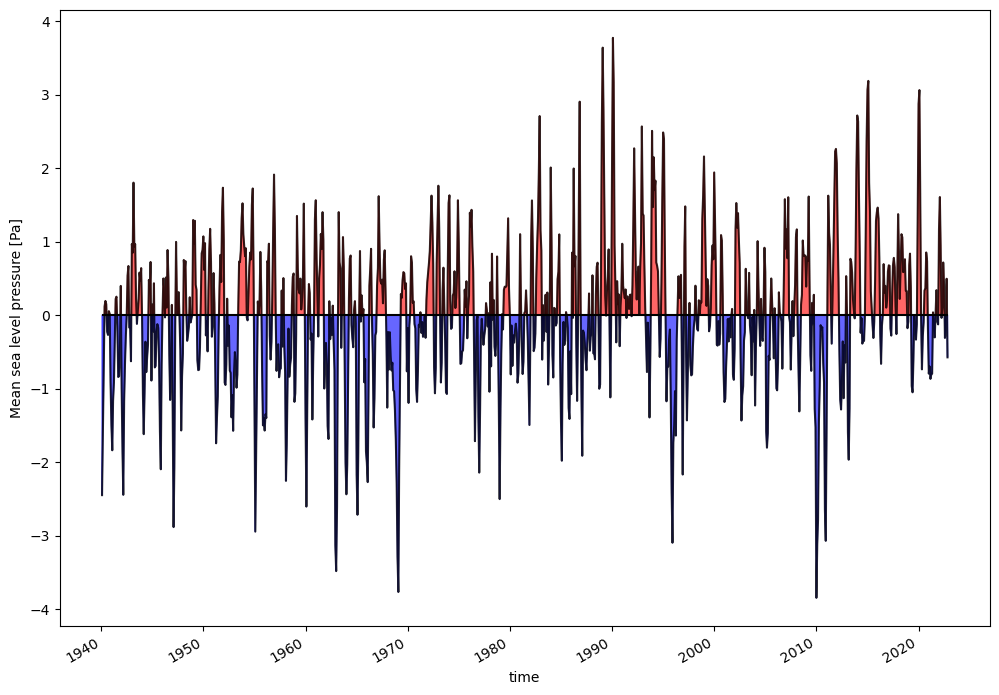

In [10]:
telec.plot_index()

## Regression evaluation

Also in this case, a specific method of the class is available to evaluate the regression map and store it in the `self.regression` attribute of the class.

In [11]:
telec.evaluate_regression()

2023-07-07 16:54:06 :: Teleconnection :: WARNING  -> Regression already calculated, skipping


Since in the most common case we want to compare the regression map with some other experiments or observations, we don't have an internal method to plot a single regression map, but a function in the diagnostic is provided to plot a map for a single experiment.

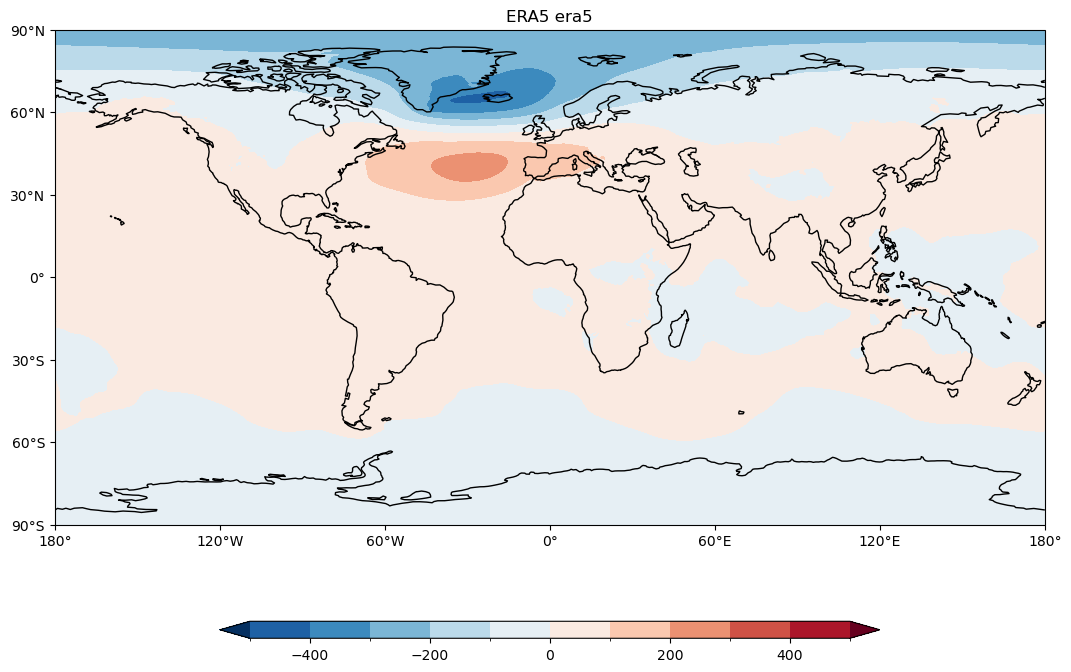

In [26]:
from teleconnections.plots import single_map_plot

single_map_plot(map=telec.regression, model=telec.model, exp=telec.exp, cbar_label='msl (Pa)', title='NAO regression of ERA5')

## Correlation evaluation

Also in this case, a specific method of the class is available to evaluate the regression map and store it in the `self.correlation` attribute of the class.


In [13]:
telec.evaluate_correlation()

2023-07-07 16:56:37 :: Teleconnection :: WARNING  -> Correlation already calculated, skipping


As before we don't have an internal method to plot a single correlation map, but the same function as before can be used.

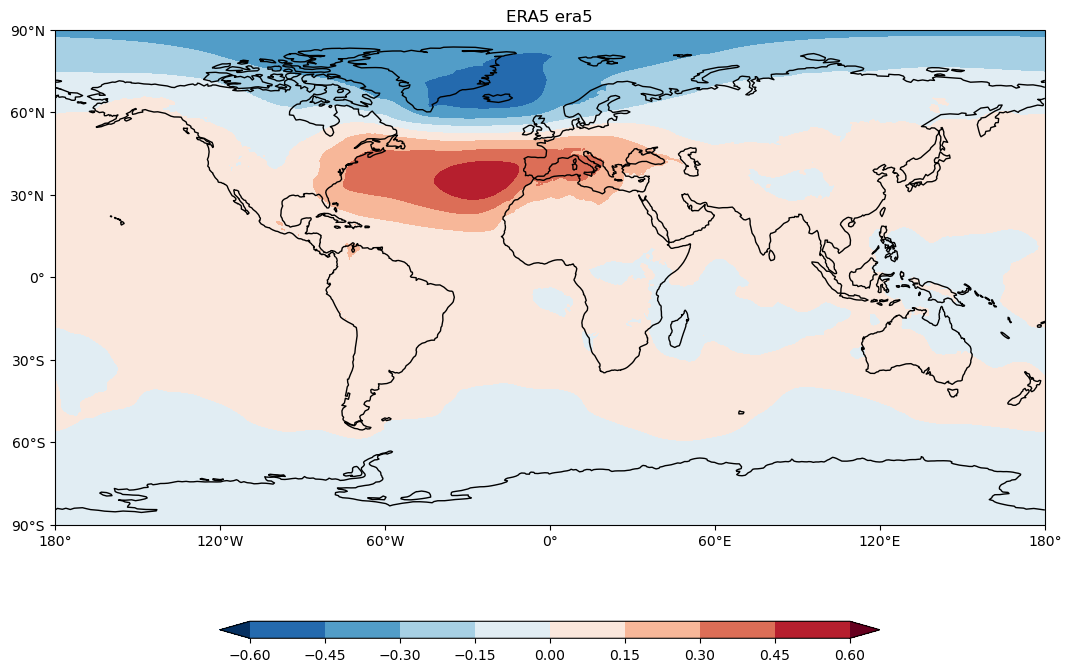

In [27]:
single_map_plot(map=telec.correlation, model=telec.model, exp=telec.exp, cbar_label='Pearson coefficient', title='NAO correlation of ERA5')

## Comparison with NCAR data

With the NAO index computed, we can compare with observational data from NCAR, to check if the index is computed correctly.
NCAR data are available in the `data` folder of the diagnostic.

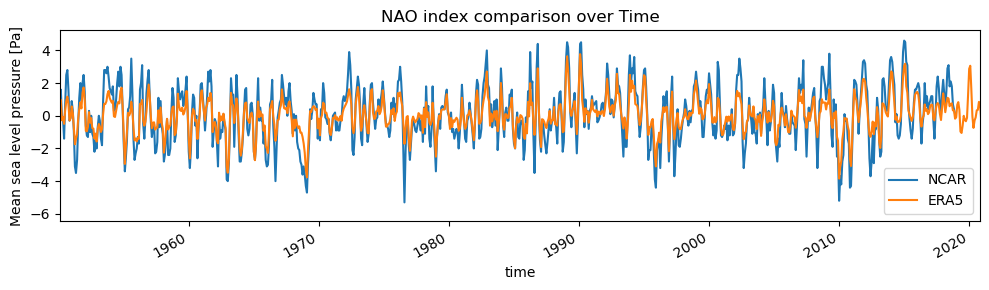

In [28]:
import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ncar_path = '../data/nao_station_seasonal.txt'
nao_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

year = nao_ncar[:,0]
month_data = nao_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
nao_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,3))
plt.plot(datetimes, nao_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1950, 1, 31, 0, 0),datetime.datetime(2020, 10, 31, 0, 0))

telec.index.plot(label='ERA5')
plt.legend()
plt.title('NAO index comparison over Time')
fig.tight_layout()

plt.show()